<a href="https://colab.research.google.com/github/dapopov-st/RagOverArXiv/blob/main/RAG_over_ArXiv_PDFs_Part7_Mistral_7b_Instruct_FinetuneSbS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step-by-Step Mistral-7b-Instruct Finetune
- Experiment with Mistral 7B Instruct Finetuning.  Honestly, not strictly necessary for the project since model performs quite well out of the box with zero-shot prompting. However, this is an opportunity to practice instruction tuning on a simple task and is good practice for future projects.
- Be careful if finetune on abstracts only as that may not be representative unless initial data RAGs over abstract as well.  Something to test, though.
- The idea is to bootstrap the fine tuning of the model on abstracts by having it predict the title since no labels are available.

Update: Looks like I found some settings/parameters that allow the model to fine tune reasonably well. The ouput produced is sensible, but need to train on more data for longer.
## Key takeaways:
- max_len = MAX_LEN is critical in the tokenizer setup!  Otherwise the model goes on generating [/INST] tokens!!!
```python tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    return_overflowing_tokens=True, #adding for shape mismatches
    max_len = MAX_LEN )
```
- tokenizer.pad_token = tokenizer.eos_token and NO tokenizer.add_eos_token config is critical for model to actually generate.  Still have a bit of an issue with model generationg [PDF] and [HTML] tags.  Can remove these or determine how to stop generation with eos while still getting the title.  Guess the data set has been trained on these tokens, so generates them as most likely next tokens after the title.  

- In TrainingArguments, max_grad_norm = 0.3 enables gradient clipping, which is *critical* for training stability (before enabling this, the loss jumped around a bit)

- 'paged' of paged optimizers helps avoid CUDA Out of Memory, introduced in QLoRA paper, I think
- dataset_text_field = 'text' used by SFTTrainer to create a packed (stitching small examples together) supervised dataset is the main column SFTTrainer uses.
Leandro von Werra: "This is a common format for instruction tuning models. In principle it can be any function that takes a row of your dataset and returns a text field. This function is applied to the whole dataset then. Note that since this is language modeling, there are no input output pairs but the whole text is input and label at the same time.  You should pass the validation set in the same format as the training dataset as they are treated the same under the hood."

- Don't make a separate wandb.init if use SFTTrainer since SFTTrainer inherits from Trainer,  which calls wandb.init under the hood.  Can also set report_to = None in SFTTrainer and call wandb.init manually, though

- Overall title quality is quite a bit better, though, for example "Introducing GAIA: A Benchmark for General AI Assistants and the Quest for Artificial General Intelligence" -> "GAIA: A Benchmark for General AI Assistants" after training the original model for only 64 steps.  Guessing this is an easy task for Mistral to learn, of course!
  

## Installs and Setup

In [ ]:
!pip install -U -q "langchain" "transformers==4.35.0" "datasets==2.12.0" "tokenizers==0.14.0" "peft==0.4.0" "accelerate==0.21.0" "bitsandbytes==0.41.1" "trl==0.4.7" "safetensors>=0.3.1" "arxiv==1.4"
#0.40.2
 #contains highly optimized components some of which are not yet available in PyTorch
!pip install -U -q xformers
!pip install -U -q wandb

In [ ]:
import transformers, datasets, tokenizers, torch
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
#transformers.__version__, datasets.__version__, tokenizers.__version__, torch.__version__

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

output_dir = '/content/drive/MyDrive/PdfRag/finetune_output_dir'
logging_dir = '/content/drive/MyDrive/PdfRag/finetune_logging_dir'
index_dir = '/content/drive/MyDrive/PdfRag/finetune_index_dir'

%cd /content/drive/MyDrive/PdfRag
!ls .


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/PdfRag
 cache										 instructionmining
 clusterofstars									 outputs
'Efficient Parallelization Layouts for Large-Scale Distributed Model Training'	 rag_index_dir
 finetune_logging_dir								 testabstract
 finetune_output_dir								 wandb


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: dpopovvelasco. Use `wandb login --relogin` to force relogin


True

In [ ]:
MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.1"

In [ ]:
# fastai function to clean GPU memory
import sys,gc,traceback
import torch
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''


def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()



In [ ]:
clean_mem()

## Load and Prepare the Data

In [ ]:
#First LOAD SMALL SLICE FOR TESTING
#Most useful way of slicing suggested here: https://huggingface.co/docs/datasets/v1.11.0/splits.html
import datasets
from copy import deepcopy
#dataset = datasets.load_dataset('CShorten/ML-ArXiv-Papers',split='train[:1%]')
dataset = datasets.load_dataset('CShorten/ML-ArXiv-Papers',split='train')

print(dataset.column_names)
# dataset = dataset['train'].train_test_split(train_size=0.95, seed=42)
# # Rename the default "test" split to "validation"
# dataset['val'] = dataset.pop("test")
orig_dataset = deepcopy(dataset)
dataset

['Unnamed: 0.1', 'Unnamed: 0', 'title', 'abstract']


Dataset({
    features: ['Unnamed: 0.1', 'Unnamed: 0', 'title', 'abstract'],
    num_rows: 117592
})

In [ ]:
orig_len=len(dataset)

In [ ]:
orig_dataset

Dataset({
    features: ['Unnamed: 0.1', 'Unnamed: 0', 'title', 'abstract'],
    num_rows: 117592
})

In [ ]:
import matplotlib.pyplot as plt
MAX_LEN = 2048
def get_reg_and_long_seq_lengths(dataset):
  seq_lens = []
  seq_long = set()
  for idx, example in enumerate(dataset):
    seq_lens.append(len(example['abstract']+example['title']))
    if seq_lens[idx] > MAX_LEN:
      seq_long.add(idx)
  return seq_lens, seq_long

def plot_seq_lens(seq_lens):
  plt.hist(seq_lens, bins = 100)
  plt.xlabel("Sequence Length")
  plt.ylabel("Count")
  plt.title("Sequence Lenghts Distribution")
  plt.show()

seq_lens, seq_long = get_reg_and_long_seq_lengths(dataset)


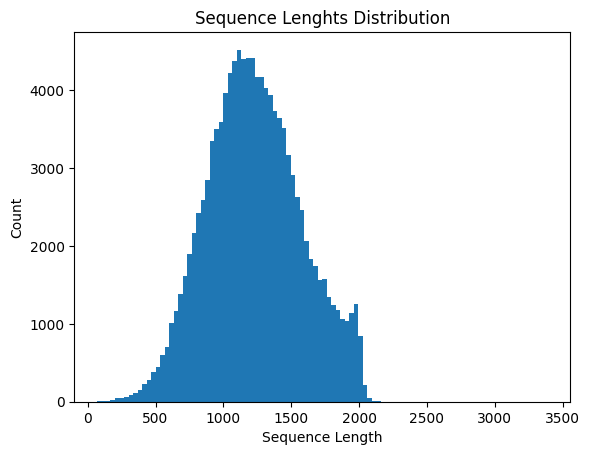

In [ ]:
plot_seq_lens(seq_lens)

In [ ]:
print(f"Percentage of sequences over {MAX_LEN}: {len(seq_long)*100/len(seq_lens)}%")
print(f"Min and max length sequences: {min(seq_lens)}, {max(seq_long)}")

Percentage of sequences over 2048: 0.11310293217225661%
Min and max length sequences: 68, 117195


In [ ]:
dataset = dataset.select(i for i in range(len(dataset)) if i not in seq_long)

In [ ]:
new_len = len(dataset)
print(f"Dropped {orig_len-new_len} out of {orig_len} examples")

Dropped 133 out of 117592 examples


- The number of validation steps is determined by the size of the validation dataset and the batch size for evaluation. Picking a very small val datasize now for speed of evaluation, ideally pick a larger one when more compute resources are available.

In [ ]:
VAL_SIZE = .0004
dataset = dataset.train_test_split(test_size=VAL_SIZE) # doing some very light evaluation,

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'title', 'abstract'],
        num_rows: 117412
    })
    test: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'title', 'abstract'],
        num_rows: 47
    })
})

- SFTTrainer expect a single 'text' column

In [ ]:
def format_prompt(sample):
    """Given a sample dictionary with keys "title" and "abstract" format into a prompt.

    Args:
      sample: A sample dictionary from a Hugging Face dataset.

    Returns:
      sample: sample dictionary with "text" key for the formatted prompt.
    """
    sample['text']=f"<s>[INST] Write a title for the following abstract {sample['abstract']} [/INST] {sample['title']}</s>"
    return sample
def preprocess_dataset(dataset):
          return (dataset
          .select(i for i in range(len(dataset)) if i not in seq_long)
          .shuffle(1337)
          .train_test_split(test_size=VAL_SIZE)
          .map(format_prompt, remove_columns=['Unnamed: 0.1', 'Unnamed: 0','title','abstract']))
dataset = preprocess_dataset(orig_dataset)

Map:   0%|          | 0/117412 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 117412
    })
    test: Dataset({
        features: ['text'],
        num_rows: 47
    })
})

## Configure Model, Data, Tokenizer, Trainer

### LoRA of QLoRA (configured in LoraConfig)
-  lora_alpha=16, # rank of the adaptor matrices, tunable hyperparam; may consider 4 or 8 to reduce number of parameters and speed up computation
-  task_type="CAUSAL_LM" for generative modeling
- Choose which layers to quantize; QLoRA paper had full quantization for intermediate layers while LoRA quantized QV.  Model printout below shows where they are coming from.


#### Q of QLoRA (quantization configured in BitsAndBytesConfig
- Enable Quantization with BitsAndBytesConfig
- Model's weights are frozen and stored in nf4 format, when need to perform compuation, confert to bf16 for stability

In [45]:

model_id = MODEL_ID
#model_id = "TheBloke/Mistral-7B-Instruct-v0.1-GGUF"
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM", #for generative modeling
    #target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj","up_proj", "down_proj"]
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"]
)

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_config = transformers.AutoConfig.from_pretrained(model_id)


model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config, #using bnb_config
    device_map='auto'
)
model.gradient_checkpointing_enable()


Fine-tune the model using a small number of parameters of an adopter layer, making the entire process faster and more memory-efficient.

In [ ]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

In [ ]:
#orig_model=model
model = prepare_model_for_kbit_training(model)

model = get_peft_model(model, peft_config)
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): Linear4bit(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(
                in_features=4096, out_features=1024, bias=False
      

- Lesson learned:  max_len = MAX_LEN is critical!  Otherwise the model goes on generating [/INST] tokens!


In [ ]:
# Load the corresponding tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    return_overflowing_tokens=True, #adding for shape mismatches
    max_len = MAX_LEN  # This is critical!  Otherwise the model goes on generating [/INST] tokens!!!
)
tokenizer.padding_side = 'right' #Warning stated to use this with decoder-only; however 'left' made trained model worse! Try right again after prompt adjustment
tokenizer.pad_token = tokenizer.eos_token

#### Testing the Original

In [ ]:
## Testing original model's output
# abstract = "We introduce GAIA, a benchmark for General AI Assistants that, if solved, would represent a milestone in AI research. GAIA proposes real-world questions that require a set of fundamental abilities such as reasoning, multi-modality handling, web browsing, and generally tool-use proficiency. GAIA questions are conceptually simple for humans yet challenging for most advanced AIs: we show that human respondents obtain 92\% vs. 15\% for GPT-4 equipped with plugins. This notable performance disparity contrasts with the recent trend of LLMs outperforming humans on tasks requiring professional skills in e.g. law or chemistry. GAIA's philosophy departs from the current trend in AI benchmarks suggesting to target tasks that are ever more difficult for humans. We posit that the advent of Artificial General Intelligence (AGI) hinges on a system's capability to exhibit similar robustness as the average human does on such questions. Using GAIA's methodology, we devise 466 questions and their answer. We release our questions while retaining answers to 300 of them to power a leader-board available at https://huggingface.co/gaia-benchmark."

# eval_prompt = f'<s>[INST] Write a title for the following abstract {abstract} [/INST]'
# model_input = tokenizer(eval_prompt, return_tensors="pt").to('cuda')

# # For some reason, could not see the ouput when using torch.no_grad()
# tokenizer.decode(orig_model.generate(**model_input, max_new_tokens=2000, temperature=0.8)[0])

# """
# <s><s> [INST] Write a title for the following abstract We introduce GAIA, a benchmark for General AI Assistants that, if solved,
# would represent a milestone in AI research. GAIA proposes real-world questions that require a set of fundamental abilities such
# as reasoning, multi-modality handling, web browsing, and generally tool-use proficiency. GAIA questions are conceptually simple
# for humans yet challenging for most advanced AIs: we show that human respondents obtain 92\% vs. 15\% for GPT-4 equipped with plugins.
# This notable performance disparity contrasts with the recent trend of LLMs outperforming humans on tasks requiring professional
# skills in e.g. law or chemistry. GAIA's philosophy departs from the current trend in AI benchmarks suggesting to target tasks
# that are ever more difficult for humans. We posit that the advent of Artificial General Intelligence (AGI) hinges on a system's
# capability to exhibit similar robustness as the average human does on such questions. Using GAIA's methodology, we devise 466
# questions and their answer. We release our questions while retaining answers to 300 of them to power a leader-board available
#  at https://huggingface.co/gaia-benchmark. [/INST] "Introducing GAIA: A Benchmark for General AI Assistants and the Quest for Artificial General Intelligence"</s>
# """

In [ ]:
clean_mem()

- 'paged' of paged optimizers helps avoid CUDA Out of Memory, introduced in QLoRA paper, I think
- dataset_text_field = 'text' used by SFTTrainer to create a packed (stitching small examples together) supervised dataset
- max_grad_norm = 0.3 enables gradient clipping, which is *critical* for training stability (before enabling this, the loss jumped around a bit)


In [ ]:
# gradient_accumulation_steps=4 with learning_rate=2e-4 kind of worked; 16 did not!
#2e-5 +16 diverges
#2e-5 +8 diverges
import transformers, trl
from datetime import datetime

project = "mistral-7b-instruct-finetune"
base_model_name = model_id
run_name = base_model_name + "-" + project

config = {
        'warmup_ratio':0.1,
        'per_device_train_batch_size':2, # Best practice: https://huggingface.co/docs/transformers/main/main_classes/quantization#tips-and-best-practices
        'per_device_eval_batch_size':2, #Otherwise will do eval over the whole data set!
        'gradient_accumulation_steps':8, #may try 1 or 4 (was working)
        'max_steps':64,
        'learning_rate':5e-5,#2.5e-5, # Want about 10x smaller than the Mistral learning rate
        'fp16':True,
        'lr_scheduler_type':"cosine"
       }

training_args = transformers.TrainingArguments(
        **config,
        output_dir=output_dir,
        optim="paged_adamw_8bit", #may try paged_adamw_32bit
        #optim="paged_adamw_32bit", #may try paged_adamw_32bit
        logging_dir=logging_dir,        # Directory for storing logs
        logging_steps=10,         #well, should have made this a mult of 8 as well
        save_strategy="steps",       # Save the model checkpoint every logging step
        evaluation_strategy="steps", # Evaluate the model every logging step
        max_grad_norm=0.3,          #Implement gradient clipping for training stability
        save_steps=4,                # Save checkpoints every 50 steps
        #evaluation_strategy="steps", # Evaluate the model every logging step
        #eval_steps=2,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        #report_to="wandb",           # Comment this out if you don't want to use weights & baises
    )

trainer = trl.SFTTrainer(
    model=model,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    #packing  = True
    dataset_text_field = 'text',
    max_seq_length = MAX_LEN

)

results = trainer.train()

#wandb.finish()
# Delete the wandb.init above in the future since SFTTrainer inherits from Trainer,
# which calls wandb.init under the hood.  Can also set report_to = None
# run = wandb.init(project="mistral7b_arxiv_finetune",
#                  name = f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",
#                  job_type="Finetuning",
#                  save_code=True,
#                  config={**config,**peft_config.to_dict()})

wandb.finish()

Map:   0%|          | 0/117412 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
10,2.716400,2.500826
20,2.385400,2.244808
30,2.206900,2.160989
40,2.143000,2.123589
50,2.095200,2.108641
60,2.111200,2.104750


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

eval/loss,█▃▂▁▁▁
eval/runtime,▅▁▂▇█▆
eval/samples_per_second,▄█▆▂▁▃
eval/steps_per_second,▃██▁▁▃
train/epoch,▁▁▁▁▁▁███████
train/global_step,▁▁▂▂▄▄▅▅▆▆▇▇█
train/learning_rate,█▇▆▄▂▁
train/loss,█▄▂▂▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [39]:
os.listdir(output_dir)

['README.md',
 'adapter_model.bin',
 'adapter_config.json',
 'checkpoint-2',
 'checkpoint-4',
 'checkpoint-6',
 'checkpoint-8',
 'checkpoint-10',
 'checkpoint-5',
 'checkpoint-15',
 'checkpoint-20',
 'final_out.pt',
 'checkpoint-25',
 'checkpoint-50',
 'checkpoint-75',
 'checkpoint-100',
 'checkpoint-12',
 'checkpoint-16',
 'checkpoint-24',
 'checkpoint-28',
 'checkpoint-32',
 'checkpoint-36',
 'checkpoint-40',
 'checkpoint-44',
 'checkpoint-48',
 'checkpoint-52',
 'checkpoint-56',
 'checkpoint-60',
 'checkpoint-64']

In [ ]:
#torch.save(model.state_dict(), output_dir+'/'+'final_out.pt')

#### Load the Model

In [ ]:
clean_mem()

In [41]:
#Likely need to restart kernel after training since o.w. run out of CUDA memory
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
model_id ="mistralai/Mistral-7B-Instruct-v0.1"
base_model_id = model_id
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)

#ft_model = PeftModel.from_pretrained(base_model, output_dir+'/'+'checkpoint-10')
#ft_model = PeftModel.from_pretrained(base_model, output_dir+'/'+'checkpoint-4')
ft_model = PeftModel.from_pretrained(base_model, output_dir+'/'+'checkpoint-64')


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


- Still have a bit of an issue with model generationg [PDF] and [HTML] tags.  Can remove these or determine how to stop generation with eos while still getting the title.  Guess the data set has been trained on these tokens, so generates them as most likely next tokens after the title.  The overall generation quality for title is much better than the original with only 64 training steps.

In [54]:
abstract = "We introduce GAIA, a benchmark for General AI Assistants that, if solved, would represent a milestone in AI research. GAIA proposes real-world questions that require a set of fundamental abilities such as reasoning, multi-modality handling, web browsing, and generally tool-use proficiency. GAIA questions are conceptually simple for humans yet challenging for most advanced AIs: we show that human respondents obtain 92\% vs. 15\% for GPT-4 equipped with plugins. This notable performance disparity contrasts with the recent trend of LLMs outperforming humans on tasks requiring professional skills in e.g. law or chemistry. GAIA's philosophy departs from the current trend in AI benchmarks suggesting to target tasks that are ever more difficult for humans. We posit that the advent of Artificial General Intelligence (AGI) hinges on a system's capability to exhibit similar robustness as the average human does on such questions. Using GAIA's methodology, we devise 466 questions and their answer. We release our questions while retaining answers to 300 of them to power a leader-board available at https://huggingface.co/gaia-benchmark."

eval_prompt = f'<s>[INST] Write a title for the following abstract {abstract} [/INST]'
model_input = tokenizer(eval_prompt, return_tensors="pt").to('cuda')

# For some reason, could not see the ouput when using torch.no_grad()
tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=50, temperature=0.8)[0])
#"GAIA: A Benchmark for General AI Assistants and the Quest for Artificial General Intelligence"
# "GAIA: A Benchmark for General AI Assistants"

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


"<s><s> [INST] Write a title for the following abstract We introduce GAIA, a benchmark for General AI Assistants that, if solved, would represent a milestone in AI research. GAIA proposes real-world questions that require a set of fundamental abilities such as reasoning, multi-modality handling, web browsing, and generally tool-use proficiency. GAIA questions are conceptually simple for humans yet challenging for most advanced AIs: we show that human respondents obtain 92\\% vs. 15\\% for GPT-4 equipped with plugins. This notable performance disparity contrasts with the recent trend of LLMs outperforming humans on tasks requiring professional skills in e.g. law or chemistry. GAIA's philosophy departs from the current trend in AI benchmarks suggesting to target tasks that are ever more difficult for humans. We posit that the advent of Artificial General Intelligence (AGI) hinges on a system's capability to exhibit similar robustness as the average human does on such questions. Using GAI

In [53]:
ft_model.generate(**model_input, max_new_tokens=50, temperature=0.8)[0]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


tensor([    1,     1,   733, 16289, 28793, 12018,   264,  3941,   354,   272,
         2296, 11576,  9713, 21861,  8342, 13945,  6958, 28724,   264, 15574,
         1633,   297, 18278, 10895,  3332, 28723,  7379, 28733,   532, 28733,
         4075,  4994, 12011,  1486, 28733, 14817,  2903,   754,   272,  1432,
         1664,  1267, 28723,  2993, 28725,  3798, 13606, 21537,  5562,  5915,
         2774,   298,  1950, 28723,   851,  3830, 15890,   264,   633,   989,
        28733, 13590,  4039,   308, 25236,  2245, 28733,   532, 28733,  9831,
         8342, 13811,  2818,   356,   272,  2245, 28733,   532, 28733,  4075,
        25236,  2229, 28723,   415,   907,  5430, 10864,  1945, 19304, 13606,
        21537,   298,  5248,   272,  2838,  1081,   302,   264,  3798, 28725,
         1312,   272,  1676,   624,   349, 19312,   298,   791, 24145, 15806,
         8342,   298,  1038, 15071,   302,   272,  6337,   304,  6697,  7898,
        28723,   816,  9584,  2856, 26569,  4644,   288, 13945, 

In [50]:
abstract = 'Multimedia generation approaches occupy a prominent place in artificial intelligence research. Text-to-image models achieved high-quality results over the last few years. However, video synthesis methods recently started to develop. This paper presents a new two-stage latent diffusion text-to-video generation architecture based on the text-to-image diffusion model. The first stage concerns keyframes synthesis to figure the storyline of a video, while the second one is devoted to interpolation frames generation to make movements of the scene and objects smooth. We compare several temporal conditioning approaches for keyframes generation. The results show the advantage of using separate temporal blocks over temporal layers in terms of metrics reflecting video generation quality aspects and human preference. The design of our interpolation model significantly reduces computational costs compared to other masked frame interpolation approaches. Furthermore, we evaluate different configurations of MoVQ-based video decoding scheme to improve consistency and achieve higher PSNR, SSIM, MSE, and LPIPS scores. Finally, we compare our pipeline with existing solutions and achieve top-2 scores overall and top-1 among open-source solutions: CLIPSIM = 0.2976 and FVD = 433.054. Project page: https://ai-forever.github.io/kandinsky-video/'
eval_prompt = f'<s>[INST] Write a title for the following abstract {abstract} [/INST]'
model_input = tokenizer(eval_prompt, return_tensors="pt").to('cuda')

# For some reason, could not see the ouput when using torch.no_grad()
tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=50, temperature=0.8)[0])
# "Latent Diffusion Text-to-Video Generation with Temporal Conditioning and MoVQ-based Decoding"
# Text-to-Video Generation: A Two-Stage Latent Diffusion Architecture for Smooth Video Synthesis # 4 steps only
# Better tuned: Kandinsky-Video: A Latent Diffusion Text-to-Video Generation Architecture

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'<s><s> [INST] Write a title for the following abstract Multimedia generation approaches occupy a prominent place in artificial intelligence research. Text-to-image models achieved high-quality results over the last few years. However, video synthesis methods recently started to develop. This paper presents a new two-stage latent diffusion text-to-video generation architecture based on the text-to-image diffusion model. The first stage concerns keyframes synthesis to figure the storyline of a video, while the second one is devoted to interpolation frames generation to make movements of the scene and objects smooth. We compare several temporal conditioning approaches for keyframes generation. The results show the advantage of using separate temporal blocks over temporal layers in terms of metrics reflecting video generation quality aspects and human preference. The design of our interpolation model significantly reduces computational costs compared to other masked frame interpolation ap